## Student Dropout Success (Graduate) Exploratory Data Analysis

### Objective
The objective of this exploratory analysis is to discover nuanced insights and relationships to help understand the factors influencing student dropout and academic success in the dataset. 

#### Loading dataset and packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as pl
from scipy import stats
import plotly.graph_objects as go
#import shap
import networkx as nx
warnings.filterwarnings('ignore', category=FutureWarning)



In [196]:
# loading teh dataset
student_data = pd.read_csv('data.csv', delimiter=';')
student_data .head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Checking data for missing values

In [197]:
# inspect the dataset shape and any missing values
print(f"Initial shape: {student_data.shape}")
student_data.info()

Initial shape: (4424, 37)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualif

### Data preprocessing

#### Outlier detection and removal

- This step involves renaming the misspelt colum 'nacionality' to Nationality.
- Also, finding and removing outliers; outliers are graduates with zero academic activity in first semester which means that they transferred to the institution.

In [198]:
# rename nacionality column 
student_data.rename(columns={'Nacionality': 'Nationality'}, inplace=True)
df = student_data.copy()

# Find and remove outliers 
grade_zero_mask = (
    (df['Target'] == 'Graduate') & 
    (df['Curricular units 1st sem (credited)'] == 0) &
    (df['Curricular units 1st sem (enrolled)'] == 0) &
    (df['Curricular units 1st sem (evaluations)'] == 0) &
    (df['Curricular units 1st sem (approved)'] == 0)
)
print(f"Found {grade_zero_mask.sum()} illogical graduates")
df = df[~grade_zero_mask] # drop the illogical graduates

Found 75 illogical graduates


75 illogical graduates were identified and dropped from the dataset because their presence in the dataset affects predicting student dropout or success. The goal is to track student performance from admission in the first semester to the time of dropping out or graduation. 

### Categorical and Hot Encoding

This step involves converting the target variable which is graduate to ordinal categories (enrolled, graduate, and dropout)

In [199]:
# Convert the Target to ordinal categories Enrolled, Graduate, and Dropout
target_order = ['Dropout', 'Enrolled', 'Graduate']
df['Target'] = pd.Categorical(df['Target'], categories=target_order, ordered=True)
df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nationality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Exploratory Data analysis

#### Correlation Matrix
To determine correlation between the numeric features.

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\seaborn\utils.py:61: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.

c:\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from font(s) DejaVu Sans.



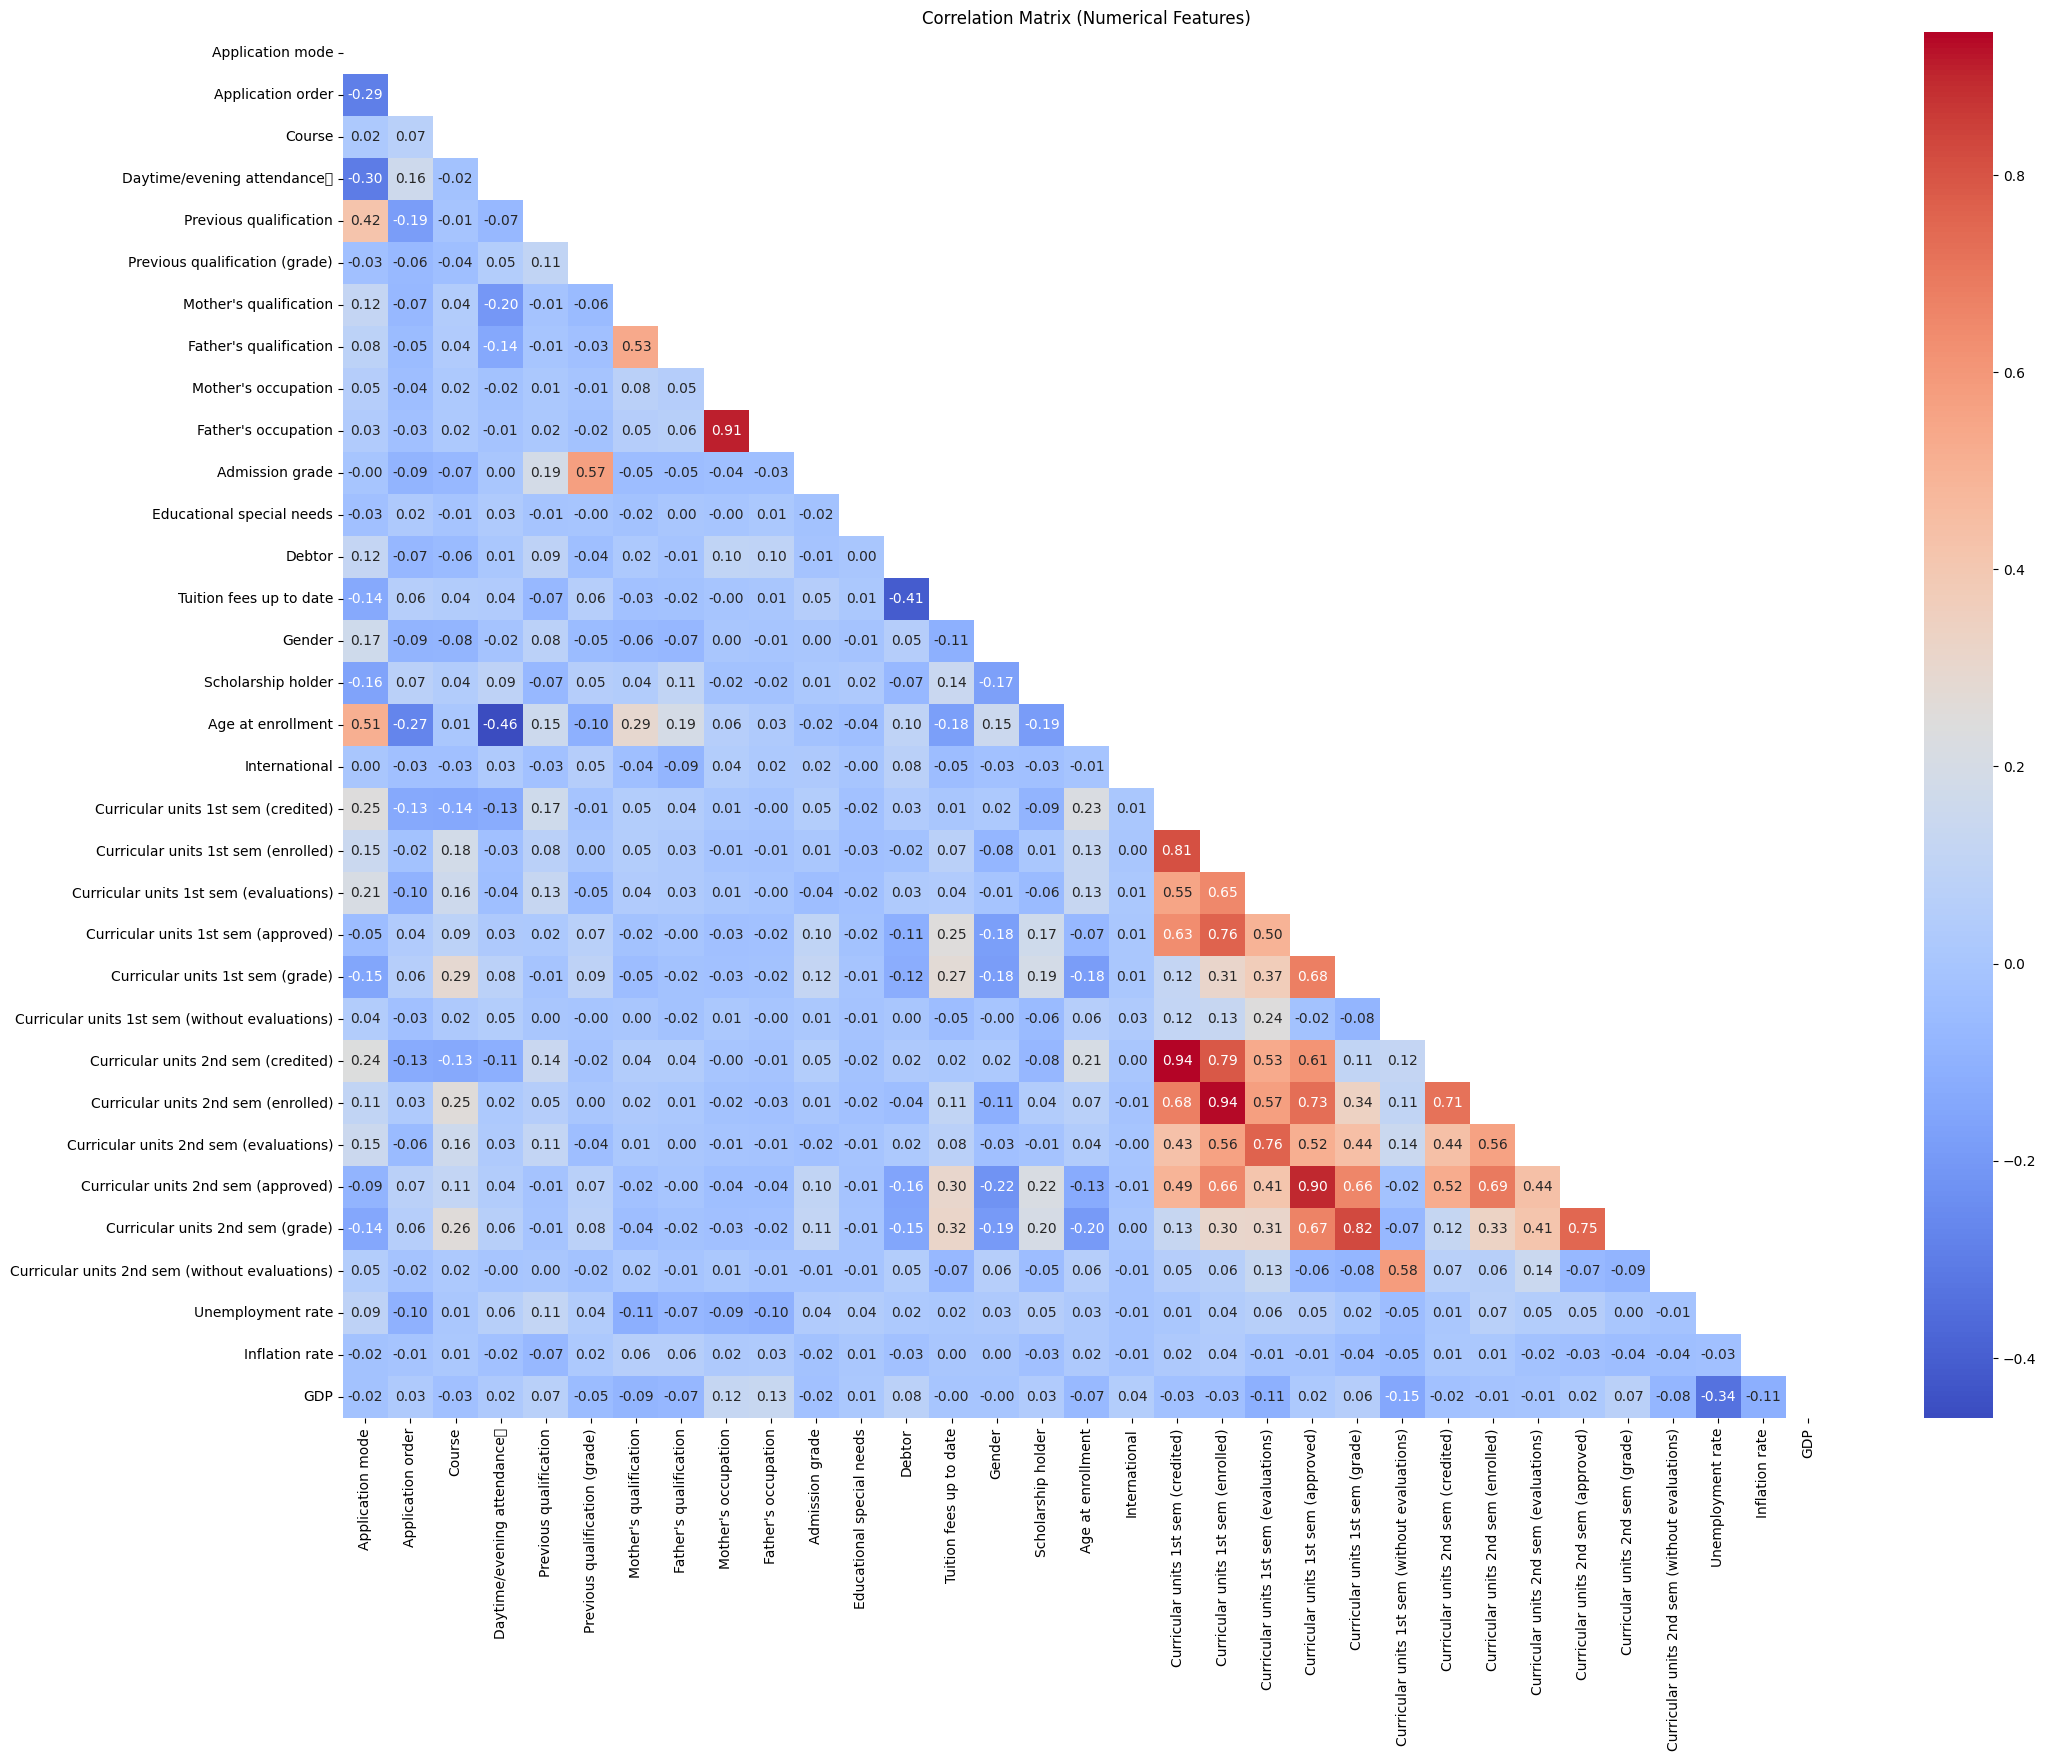

Variables with Strong Correlations:
                             Variable 1                           Variable 2  \
0   Curricular units 2nd sem (credited)  Curricular units 1st sem (credited)   
1   Curricular units 1st sem (credited)  Curricular units 2nd sem (credited)   
2   Curricular units 1st sem (enrolled)  Curricular units 2nd sem (enrolled)   
3   Curricular units 2nd sem (enrolled)  Curricular units 1st sem (enrolled)   
4                   Father's occupation                  Mother's occupation   
5                   Mother's occupation                  Father's occupation   
6   Curricular units 2nd sem (approved)  Curricular units 1st sem (approved)   
7   Curricular units 1st sem (approved)  Curricular units 2nd sem (approved)   
8      Curricular units 1st sem (grade)     Curricular units 2nd sem (grade)   
9      Curricular units 2nd sem (grade)     Curricular units 1st sem (grade)   
10  Curricular units 1st sem (credited)  Curricular units 1st sem (enrolled)   
11  

In [202]:
# correlation matrix
corr_matrix = df.select_dtypes(include=np.number).corr()

# Plot correlation matrix
plt.figure(figsize=(24, 18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=np.triu(np.ones_like(corr_matrix)))
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

#  threshold for strong correlations
threshold = 0.8

# Extract pairs of variables with strong correlations
strong_correlations = corr_matrix.unstack().sort_values(ascending=False)
strong_correlations = strong_correlations[(strong_correlations.abs() > threshold) & (strong_correlations < 1.0)]  

# Convert to DataFrame 
strong_correlations_df = pd.DataFrame(strong_correlations).reset_index()
strong_correlations_df.columns = ['Variable 1', 'Variable 2', 'Correlation']

# Display strong correlations
print("Variables with Strong Correlations:")
print(strong_correlations_df)

#### Bar plot 
A bar plot to visualize the distribution of target variable

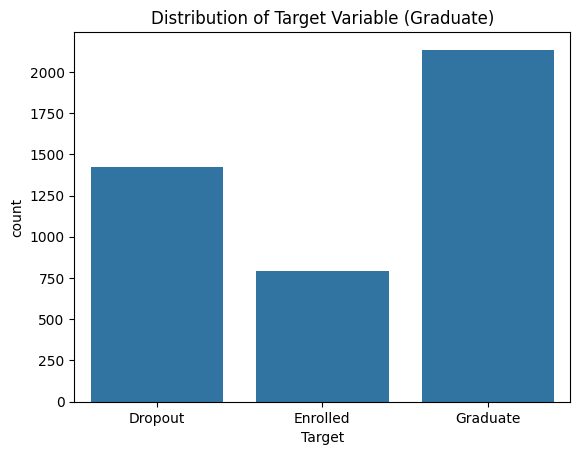

In [203]:
# Plot distribution of the target variable
sns.countplot(x='Target', data=df)
plt.title('Distribution of Target Variable (Graduate)')
plt.show()

#### Comparising performance for Target variable
Involves using a box plot to show performance on approved curricular units for semester 1 by graduation status.

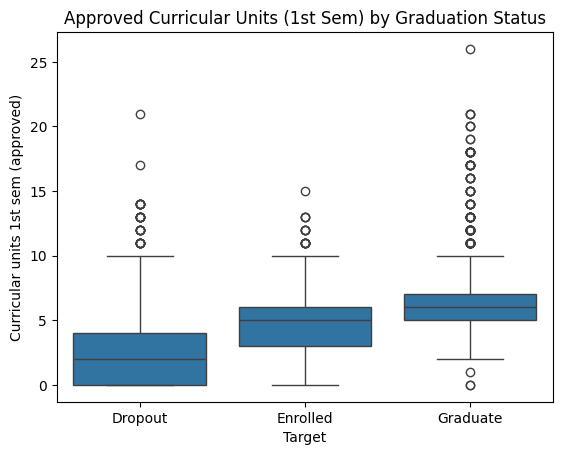

In [204]:
# Compare academic performance for graduates vs. non-graduates
sns.boxplot(x='Target', y='Curricular units 1st sem (approved)', data=df)
plt.title('Approved Curricular Units (1st Sem) by Graduation Status')
plt.show()

The box plots show that the number of approved curricular units in the first semester varies significantly between students who dropped out, those still enrolled, and those who graduated. Graduates have the highest number of approved units on average, while dropouts have the lowest average number of approved units. 

#### Temporal Analysis 
A temporal analysis compares 2nd semember performance and the performance outcome.
It involves creating KDE plot for the target variable against the different performance metrics for the second semester.
The goal is to help identify the influence of 2nd semester performance of the student outcome and the trends/patterns.

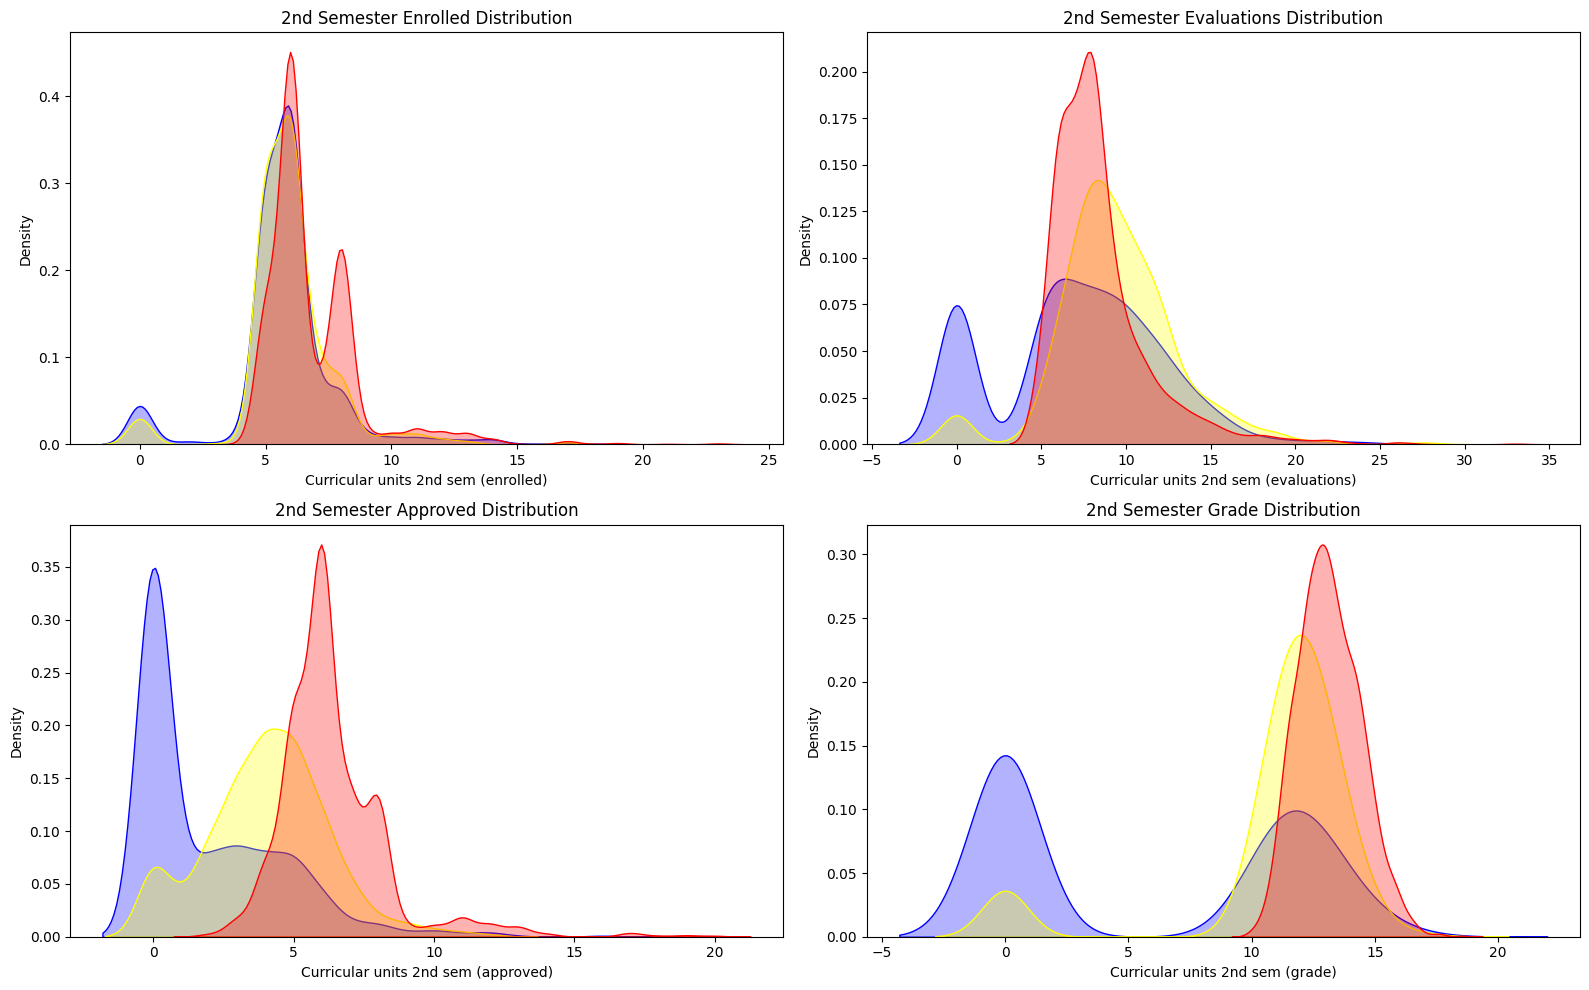

In [164]:
# temporal analysis
semester_metrics = ['enrolled', 'evaluations', 'approved', 'grade']
palette = {'Dropout': 'blue', 'Enrolled': 'yellow', 'Graduate': 'red'}

# ccreate subplots
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
for i, metric in enumerate(semester_metrics):
    ax = axs[i//2, i%2]
    for target in target_order:
        sns.kdeplot(
            data=df[df['Target'] == target],
            x=f'Curricular units 2nd sem ({metric})',  # Compare 2nd semester performance
            fill=True, alpha=0.3, 
            label=target, ax=ax, color=palette[target]
        )
    ax.set_title(f'2nd Semester {metric.capitalize()} Distribution')
plt.tight_layout()

The first KDE plot shows that the enrollment distribution which is relatively similar for dropout (blue), graduate (red), and enrolled (yellow). The 2nd semester evaluation distribution shows that a signficant portion reach graduation, about half remain enrolled, while the rest dropout.
The Approved units distribution shows that most of the students who dropout have fewer number of curricular units approved, below 5 units. Most of them have 0 approved units. Those who remain enrolled at the end have about 5 units approved. while those who graduate have most units approved with some having more than 10 curricular units approved.
For grade disribution, almost all students who graduate have at least 10 curricular units graded while those who dropout have 0 units graded and some have about 12 units graded.

#### Interaction between semester performance
This involved sampling 1000 students from the dataset and comparing the number of units approved in semesters 1 and 2 to determine how it affects the performance outcome (target variable)

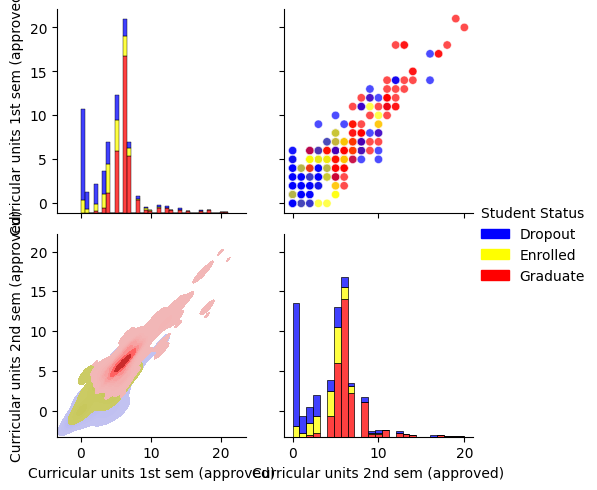

In [165]:
# Interaction Analysis - Cross-semester Performance
g = sns.PairGrid(df.sample(1000), 
                 vars=['Curricular units 1st sem (approved)',
                       'Curricular units 2nd sem (approved)'],
                 hue='Target', palette=palette)
g.map_upper(sns.scatterplot, alpha=0.7)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, multiple='stack')
g.add_legend(title='Student Status')

The plot for cross-semester interaction above shows that students who have a fewer number of approved units in 1st semester are more likely to dropout. Students who graduate have higher nuber of approved units in 1st semester and 2nd semester as well. 

#### Violin Plot
To show how age at enrollment influences performance outcome.

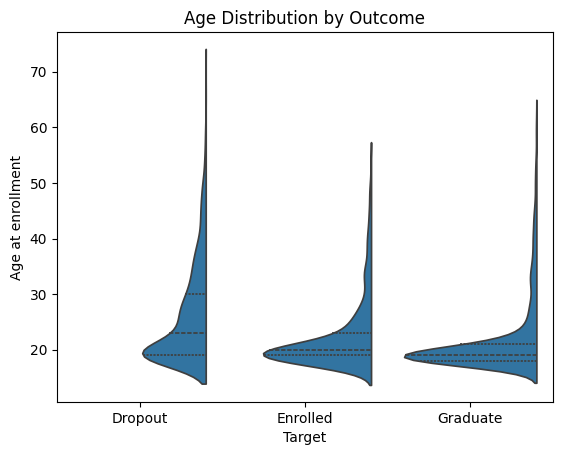

In [183]:
target = 'Target' 
sns.violinplot(x=target, y='Age at enrollment', data=df, split=True, inner='quartile')
plt.title("Age Distribution by Outcome")
plt.show()

The plot shows that age at enrollment signficantly impacts performance outcome. For graduate, most of the learners joined at an average age of 20 while dropout's age strenches to 50. The Age distribution for dropout has thicker tails compared to graduate and enrolled, indicating that more learners who dropout join or get enrolled at older ages.

#### Sankey diagram 
- This involves creating a sankey diagram and mapping the target variables to determie the path learners take based on performance clusters - low, mid, and high performance. It uses admission grade, 1st and second semester grades to create clusters
- This helps answer the question on whether there is a relationship between performance and dropping out of the course.

In [ ]:
#  Create Performance Clusters
# Use admission grades, grades from the first and second semesters for clustering
cluster_features = ['Admission grade', 'Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']
# ['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']
X = df[cluster_features].fillna(0)

# Standardize
X_scaled = StandardScaler().fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['performance_cluster'] = kmeans.fit_predict(X_scaled)

# Map cluster to performance levels
df['performance_cluster'] = df['performance_cluster'].map({0: 'Low', 1: 'Mid', 2: 'High'})

# Map performance clusters to Target Outcomes grouped by performance cluster and target outcome
pathway = df.groupby(['performance_cluster', 'Target']).size().reset_index(name='count')

# Sankey Diagram
nodes = pd.unique(pathway[['performance_cluster', 'Target']].values.ravel('K'))
node_indices = {node: i for i, node in enumerate(nodes)}

# Map source and target 
pathway['source'] = pathway['performance_cluster'].map(node_indices)
pathway['target'] = pathway['Target'].map(node_indices)

# Create Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes
    ),
    link=dict(
        source=pathway['source'],
        target=pathway['target'],
        value=pathway['count']
    )
)])
# plot
fig.show()

The performance outcome pathways show that most middle and high performance graduate. A few low performance students graduate or remain enrolled. Nearly all high performance learners graduate.

### Determining high achiever dropouts
- This involves determining students with 1st semester grades who rank among top 10 and end up dropping out of the course. 
- A plot of 1st semester approved units and grades in second semester will show the high achiever dropouts. 

Text(10, 15, 'High Grade Dropouts')

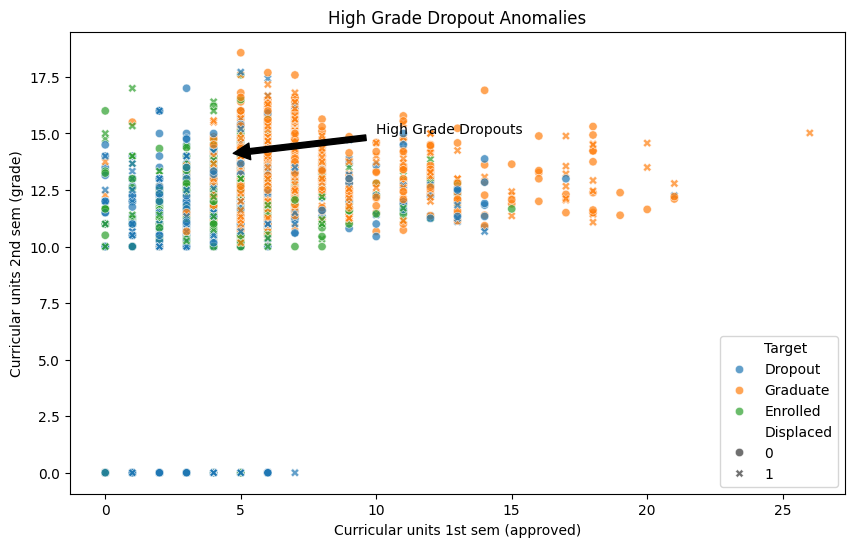

In [185]:
# detecting outlier - High Achiever Dropouts
df2 = pd.read_csv('data.csv', delimiter=';')
high_grade_dropouts = df2[
    (df2['Curricular units 1st sem (grade)'] > 16) &  # Top 10 percent of grades
    (df2['Target'] == 'Dropout')
]

plt.figure(figsize=(10,6))
sns.scatterplot(
    x='Curricular units 1st sem (approved)',
    y='Curricular units 2nd sem (grade)',
    hue='Target',
    style='Displaced',
    data=df2,
    alpha=0.7
)
plt.title("High Grade Dropout Anomalies")
plt.annotate(
    'High Grade Dropouts', 
    xy=(high_grade_dropouts['Curricular units 1st sem (approved)'].mean(),
        high_grade_dropouts['Curricular units 2nd sem (grade)'].mean()),
    xytext=(10, 15),
    arrowprops=dict(facecolor='black', shrink=0.05)
)

The plot above shows students who had grades above 10.0 points number of units approved. High grade dropouts are outliers and can help determine which of the features predict high performance students to dropout. 

#### Cohort Analysis
- This involves assigning synthetic enrollment year to help track outcomes across cohorts, helping identify trends or changes in cohort. 
- The years 2015 to 2018 are assigned and the participants grouped by year to have a cohort for each of the 4 years.
The cohort analysis plot is created to show outcome trends by enrollment cohort. 

Text(0, 0.5, 'Number of Students')

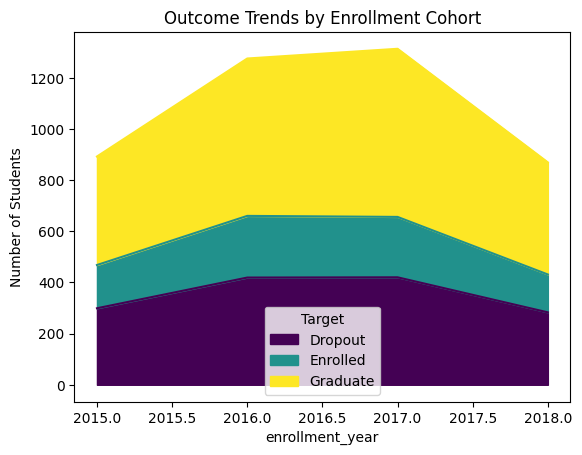

In [175]:
# Create synthetic enrollment years 
np.random.seed(42)
df['enrollment_year'] = np.random.choice(
    [2015, 2016, 2017, 2018], 
    size=len(df),
    p=[0.2, 0.3, 0.3, 0.2]
)

cohort_analysis = df.groupby(['enrollment_year', 'Target']).size().unstack()
cohort_analysis.plot(kind='area', stacked=True, colormap='viridis')
plt.title("Outcome Trends by Enrollment Cohort")
plt.ylabel("Number of Students")

**Interpretation**
The cohort analysis plot above shows that a higher proportion of the students graduated. There is a trend of increasing enrolled, dropout, and graduate over the years.

#### Correlation Network
- The course correlation network helps uncover network relationships on academic performance for the different curricular units.
- This involves creating a correlation matrix for curricular units and extracting those with strong correlations, greater than 0.7

Text(0.5, 1.0, 'Network Relationships for Academic Performance')

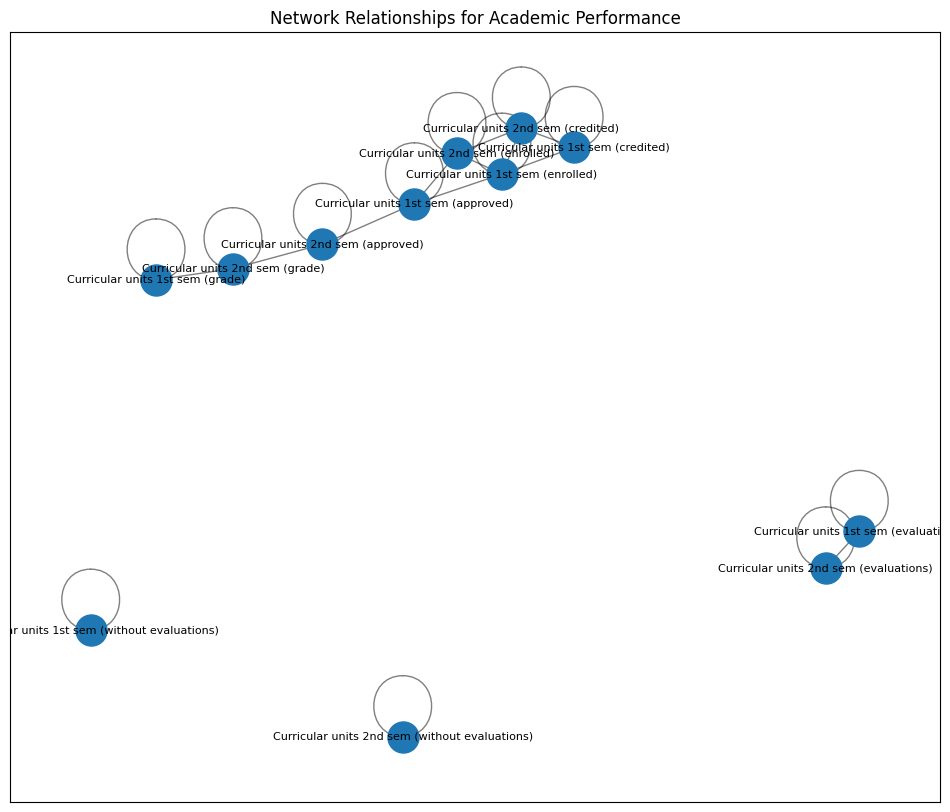

In [186]:
# correlation network for curricular units
corr_matrix = df.filter(regex='Curricular units').corr()
# correlations greater than 0.7
G = nx.Graph(corr_matrix.abs() > 0.7)  

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Network Relationships for Academic Performance")


The correlation network shows that performance in the first semester strongly influences performance in the second semester. The students who perform well in the first semester are more likely to perform well in the second semeter. This is also similar in the cluster involve curricular units in 1st and 2nd semeter (approved) and the grades for the semesters. They grades in 1st sem influence 2nd sem grades and approval of curricular units in 2nd semester. 
This means that, performance problems in year 1 leads to further problems such as fewer number of units being approved in 2nd semester and also affects performance during the second semester.

#### Clustering using K-Means
- Selected features are grades, age, socioeconomic status - if student has a scholarship or not, to create clusters and uncover any hidden cluster.
- This helps answer the question whether learners have similar performance behavior based on admission grade, age, or scholarship

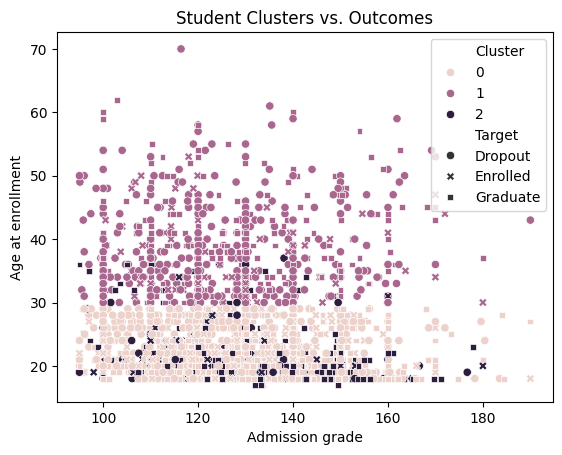

In [187]:
# Selected features are grades, age, socioeconomic status 
cluster_features = ['Admission grade', 'Age at enrollment', 'Scholarship holder']
X = df[cluster_features].dropna()
X_scaled = StandardScaler().fit_transform(X)

# Perform K-means
kmeans = KMeans(n_clusters=3, random_state=42)
df_cluster = X.assign(Cluster=kmeans.fit_predict(X_scaled), Target=df['Target'])

# Visualize clusters vs. outcomes
sns.scatterplot(x='Admission grade', y='Age at enrollment', hue='Cluster', style='Target', data=df_cluster)
plt.title("Student Clusters vs. Outcomes")
plt.show()

#### Bar plot to compare debt-status and performance outcome
Comparing student outcome between debtors vs non-debtors. Does holding debt impact student outcome such as debt contributing to dropping out of college?

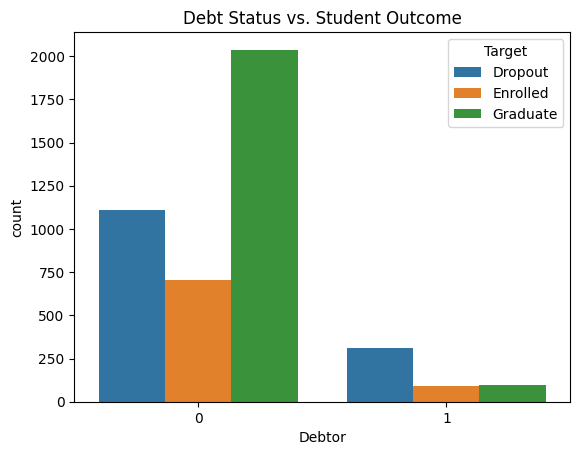

In [172]:
# Debtors vs. Non-Debtors 
if 'Debtor' in df.columns:
    sns.countplot(x='Debtor', hue='Target', data=df)
    plt.title("Debt Status vs. Student Outcome")
    plt.show()

The output shows that there are higher dropout rates among students who hold debt. While on first impression, the non-debtors show higher count in graduation, enrollment and dropout, comparing the number of students in each category shows a relatively higher dropouts in debtor category.

#### Determining the top 10 factors influencing student dropout.
This involves encoding the target variable and fitting the Random Forest model to determine the top 10 features/factors in predicting student dropout rates.

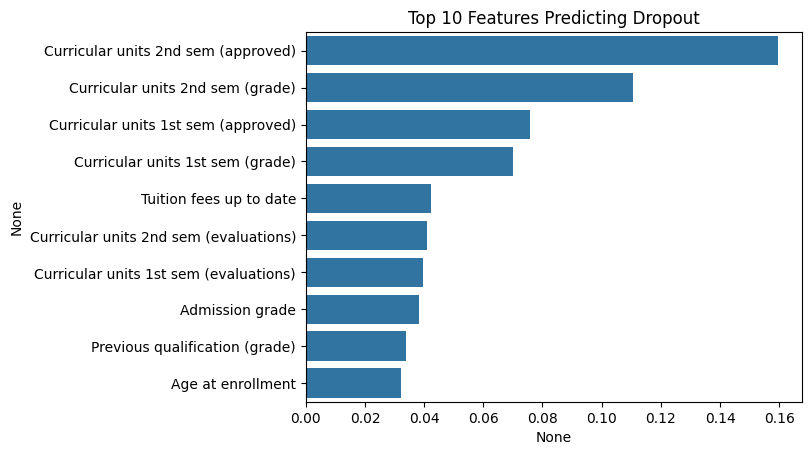

In [188]:
# Encoding target
le = LabelEncoder()
y = le.fit_transform(df['Target'])
X = df.drop(columns=['Target']).select_dtypes(include=np.number).fillna(0)

# Fit model
model = RandomForestClassifier()
model.fit(X, y)

# Plot 
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importance[:10], y=feature_importance.index[:10])
plt.title("Top 10 Features Predicting Dropout")
plt.show()

The bar chart shows that curricular units approved in the 2nd Semester is the most importance predictor of student dropout. This is followed by 2nd semester grade, curricular units approved in first semester, 1st and 2nd semester evaluations, admission grade, age of enrollment, previous grade, and performance cluster.

#### Using the top 10 Features for further analysis
The aim is to find out if 
- dropouts have significantly fewer approved units or lower grades in early semesters
- there is a clear age threshold such as older students struggle more

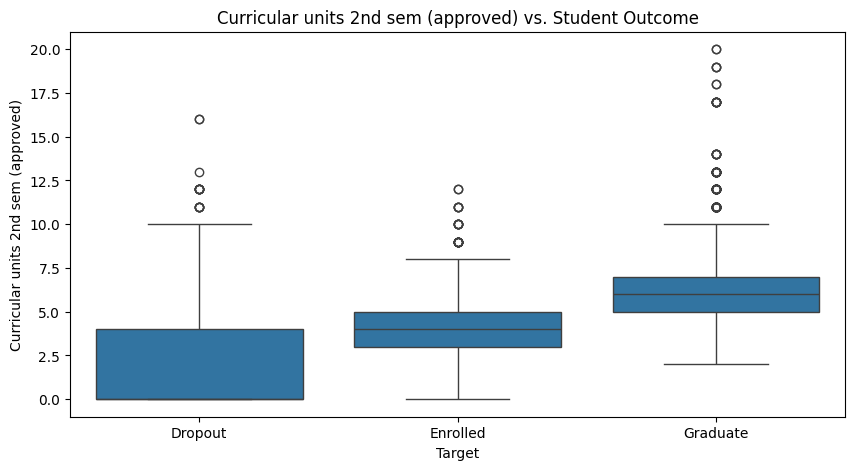

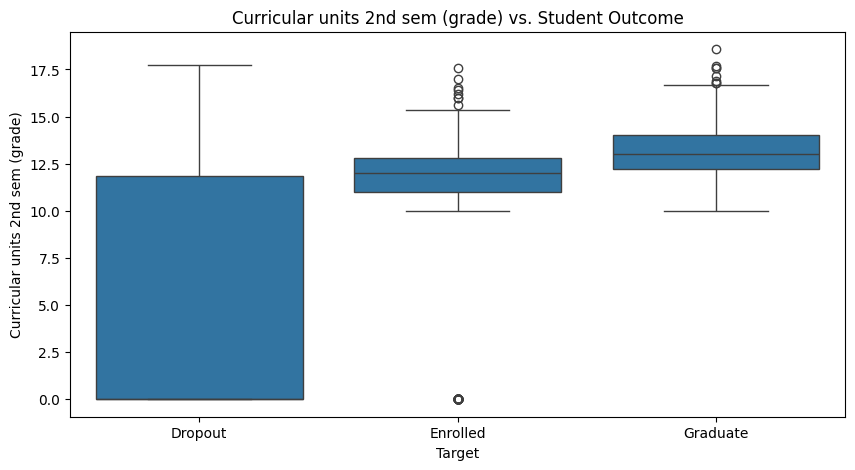

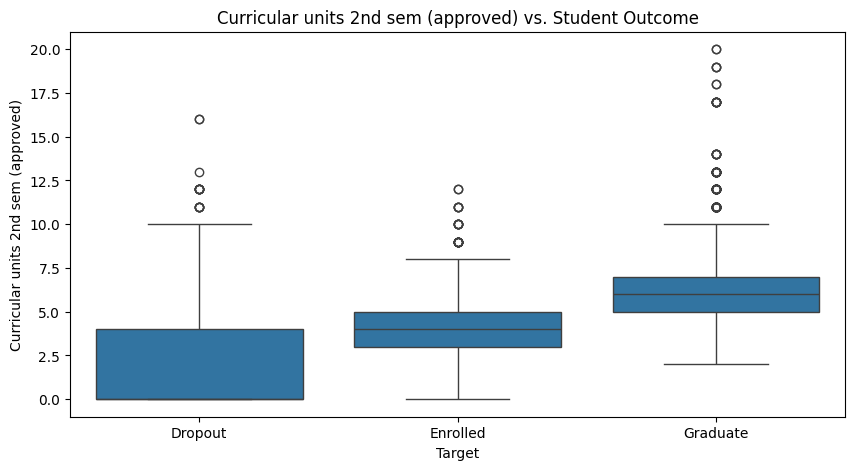

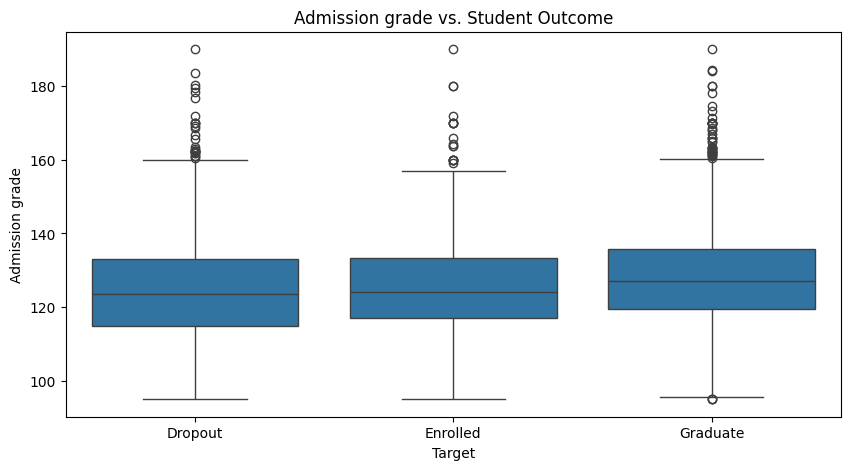

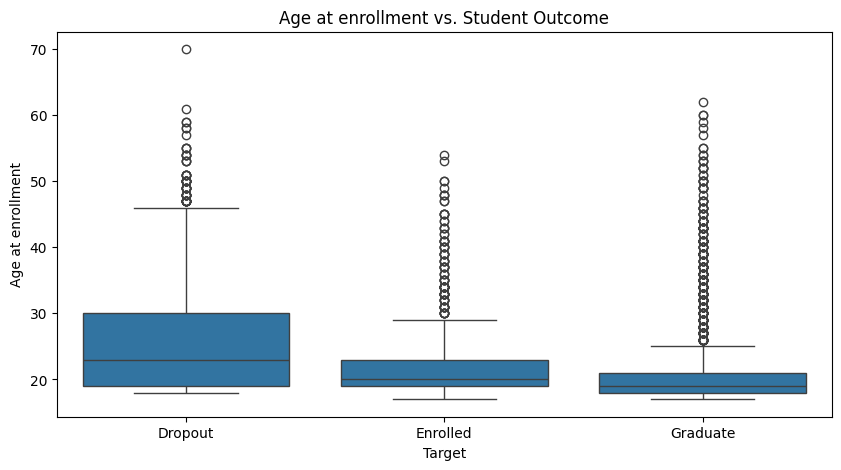

In [222]:
top_features = [
    'Curricular units 2nd sem (approved)', 
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (approved)',
    'Admission grade', 
    'Age at enrollment'
]

for feature in top_features:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='Target', y=feature, data=df)
    plt.title(f"{feature} vs. Student Outcome")
    plt.show()

**Interpretation**
- Students who have higher number of units approved and graded during the 1st and second semesters are more likely to graduate.
- Most of the students who graduate enroll at a relatively young age on average while the student who dropout, their ages range variably. 
- The admission grade influences the dropout/success rate with students who join with low grades more likely to dropout.


#### LM Plot admission grade vs 1st semester grade on target variable
This is to find out if students with low admission grades AND low 1st-semester grades have the highest dropout risk.

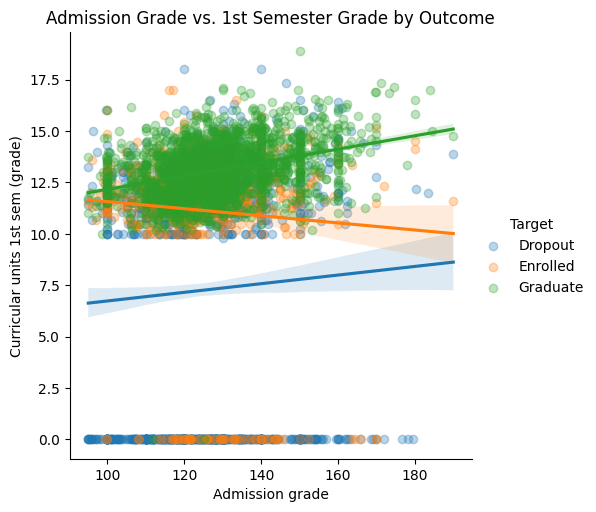

In [177]:
# An lm plot of Admission Grade vs. 1st Semester Grade by Outcome
sns.lmplot(
    x='Admission grade', 
    y='Curricular units 1st sem (grade)', 
    hue='Target', 
    data=df, 
    scatter_kws={'alpha': 0.3}
)
plt.title("Admission Grade vs. 1st Semester Grade by Outcome")
plt.show()

The plot shows that students with low admission grade and low first semeter grade are more likely to dropout. Students with median admission grade between 110 and 140, and high grades in 1st semester are more likely to graduate.

#### Clustering for Admission grade, 1st seme grade, and age at enrollment

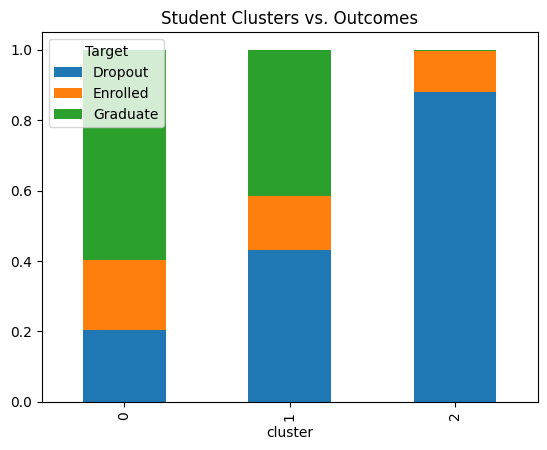

In [193]:
# Using the top numerical features
cluster_cols = ['Admission grade', 'Curricular units 1st sem (grade)', 'Age at enrollment']
X = df[cluster_cols].dropna()
X_scaled = StandardScaler().fit_transform(X)

# K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Comparing clusters to outcomes
pd.crosstab(df['cluster'], df['Target'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Student Clusters vs. Outcomes")
plt.show()

The plot shows that nearly all the students who dropout have low admission grades and older age at enrollment (cluster 1). The admission grade signficantly influences the likelihood of graduating.

#### Logistic Regression Model

In [ ]:
# Encode target and features
X = df[top_features].fillna(0)
y = LabelEncoder().fit_transform(df['Target'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Fit model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.75       430
           1       1.00      0.00      0.01       223
           2       0.73      0.94      0.82       652

    accuracy                           0.73      1305
   macro avg       0.82      0.57      0.53      1305
weighted avg       0.77      0.73      0.66      1305



c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



**Interpretation**
The regression model is predict the target variable (0 - Enrolled, 1-Graduate, and 2- Dropout)
The Lostic regression performed reasonably well with a precision of 0.71 and recall of 0.78 in predicting dropout. This means it correctly identifies 78% of actual dropout instances while maintaining high precision. The model struggles with a precision of 1.0 and a very low recall of 0.0 in predicting erolled. This indicates that it fails to identify most instances of enrolled. The model performs best for graduate with a high recall of 0.94 and precision of 0.73. This means that it captures most graduate instances but has some false positives.

### Findings and Recommendations

- Students who perform well in the first semester, particularly those with higher admission grades, are more likely to graduate. 
- Students with with low admission grades, poor first-semester performance, and fewer approved curricular units are at a higher risk of dropping out. 
- The strong correlation between first- and second-semester performance signfies the importance of addressing academic challenges early to prevent difficulties in subsequent semesters. 
- It is recommended that educational institutions and students put interventions to improve first-semester performance especially for students with lower admission grades to enhance retention and increase graduation rates. 
-In addition, the EDA suggests that older students with low admission grades are more likely to drop out, indicating a need for targeted support for this demographic.